In [ ]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import tensorflow as tf
from tensorflow.keras import layers, models
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
cifar_folder = './cifar/'

# CIFAR-10 normalization values
cifar_mean = [0.4914, 0.4822, 0.4465]
cifar_std = [0.247, 0.243, 0.261]

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=cifar_mean, std=cifar_std)
])

# Load the dataset with normalization
cifar_dataset = torchvision.datasets.CIFAR10(root=cifar_folder, train=True, download=True, transform=transform)


# Séparation en ensembles d'entraînement et de test
train_size = int(0.8 * len(cifar_dataset))
test_size = len(cifar_dataset) - train_size
train_dataset, test_dataset = random_split(cifar_dataset, [train_size, test_size])

# Création des DataLoader
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Classes dans CIFAR-10
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')



Files already downloaded and verified


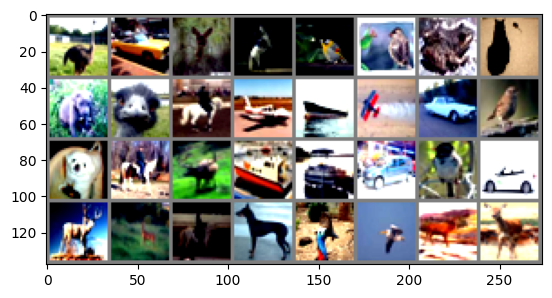

Labels: bird car deer horse bird bird frog cat dog bird horse plane ship plane car bird dog horse deer ship ship car bird car deer deer horse dog bird bird deer deer


In [ ]:
# Fonction pour afficher des images
def imshow(img):
    img = img / 2 + 0.5     # Dénormalisation
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Obtenir quelques images d'entraînement
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Afficher les images
imshow(torchvision.utils.make_grid(images))
print('Labels:', ' '.join(f'{classes[labels[j]]}' for j in range(batch_size)))

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

class BasicModel(nn.Module):
    def __init__(self):
        super(BasicModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1) # Convolutional layer (3x3 kernel)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1) # Convolutional layer (3x3 kernel)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1) # Convolutional layer (3x3 kernel)
        self.pool = nn.MaxPool2d(2, 2) # Max pooling layer (2x2 pool size)
        self.batch_norm1 = nn.BatchNorm2d(32) # Batch normalization for the first conv layer
        self.batch_norm2 = nn.BatchNorm2d(64) # Batch normalization for the second conv layer
        self.batch_norm3 = nn.BatchNorm2d(128) # Batch normalization for the third conv layer
        self.dropout1 = nn.Dropout(0.25) # Dropout with 25% probability
        self.dropout2 = nn.Dropout(0.5) # Dropout with 50% probability
        self.fc1 = nn.Linear(128 * 4 * 4, 512) # Fully connected layer (reducing number of neurons)
        self.fc2 = nn.Linear(512, 10) # Fully connected layer (10 classes for CIFAR-10)

    def forward(self, x):
        x = self.pool(F.relu(self.batch_norm1(self.conv1(x)))) # Activation -> BatchNorm -> Pooling
        x = self.pool(F.relu(self.batch_norm2(self.conv2(x)))) # Activation -> BatchNorm -> Pooling
        x = self.pool(F.relu(self.batch_norm3(self.conv3(x)))) # Activation -> BatchNorm -> Pooling
        x = torch.flatten(x, 1) # Flatten the tensor for the fully connected layer
        x = self.dropout1(x) # Apply dropout before the first FC layer
        x = F.relu(self.fc1(x)) # Activation for the first FC layer
        x = self.dropout2(x) # Apply dropout before the second FC layer
        x = self.fc2(x) # No activation, raw scores to be passed to the loss
        return x


# Initialiser le modèle
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = BasicModel().to(device)

# Définir la fonction de perte et l'optimiseur
criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)


# Entraîner le modèle
for epoch in range(5):  # Boucler sur les epochs
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 2000 == 1999:  # Imprimer toutes les 2000 mini-batchs
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

Finished Training


In [ ]:
# Tester le modèle
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy on test images: %d %%' % (100 * correct / total))

Accuracy on test images: 69 %


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class RandomizedNet(nn.Module):
    def __init__(self):
        super(RandomizedNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        # Apply dropout after convolutional layers
        self.dropout_conv = nn.Dropout2d(p=0.2)

        self.fc1 = nn.Linear(64 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, 10)
        # Apply dropout after fully connected layers
        self.dropout_fc = nn.Dropout(p=0.5)

    def forward(self, x, apply_dropout=False):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = self.dropout_conv(x) if apply_dropout else x

        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = self.dropout_conv(x) if apply_dropout else x

        x = x.view(x.size(0), -1)  # Flatten the tensor

        x = F.relu(self.fc1(x))
        x = self.dropout_fc(x) if apply_dropout else x

        x = self.fc2(x)
        return F.log_softmax(x, dim=1)







In [ ]:
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model
model = RandomizedNet().to(device)

# Assume we have a DataLoader named 'test_loader' for our test dataset

# Initialize counters for correct predictions and total samples
correct = 0
total = 0

# Place the model in evaluation mode
model.eval()

# Define the number of forward passes
num_forward_passes = 50

# Loop through the test dataset
for data, target in test_loader:
    data, target = data.to(device), target.to(device)
    # Initialize the tensor to accumulate outputs
    # The shape should be [num_forward_passes, batch_size, num_classes]
    output_accumulate = torch.zeros(num_forward_passes, data.size(0), 10, device=device)  # Assuming 10 classes for CIFAR-10

    # Perform multiple forward passes and accumulate outputs
    with torch.no_grad():
        for i in range(num_forward_passes):
            outputs = model(data, apply_dropout=True)
            output_accumulate[i] = outputs

    # Calculate mean across the forward passes
    mean_outputs = output_accumulate.mean(0)

    # The predicted class is the one with the highest mean score
    _, predicted = mean_outputs.max(1)

    # Update correct count
    correct += (predicted == target).sum().item()
    total += target.size(0)

# Calculate the overall accuracy
accuracy = correct / total
print(f'Accuracy of the network on the test images: {100 * accuracy:.2f}%')




Accuracy of the network on the test images: 8.90%


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BasicModel(nn.Module):
    def __init__(self):
        super(BasicModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.batch_norm1 = nn.BatchNorm2d(32)
        self.batch_norm2 = nn.BatchNorm2d(64)
        self.batch_norm3 = nn.BatchNorm2d(128)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x, apply_dropout=False):
        x = self.pool(F.relu(self.batch_norm1(self.conv1(x))))
        x = self.pool(F.relu(self.batch_norm2(self.conv2(x))))
        x = self.pool(F.relu(self.batch_norm3(self.conv3(x))))
        x = torch.flatten(x, 1)  # Flatten the tensor for the fully connected layer
        x = self.dropout1(x) if apply_dropout else x  # Apply dropout if flag is true
        x = F.relu(self.fc1(x))
        x = self.dropout2(x) if apply_dropout else x  # Apply dropout if flag is true
        x = self.fc2(x)
        return x


In [ ]:
import torch
from torch.utils.data import DataLoader
# Assuming BasicModel is already defined as per the previous instructions

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model
model = BasicModel().to(device)

# Assume we have a DataLoader named 'test_loader' for our test dataset
# test_loader = DataLoader(...) # you need to create or load your DataLoader here

# Initialize counters for correct predictions and total samples
correct = 0
total = 0

# Place the model in evaluation mode
model.eval()

# Define the number of forward passes
num_forward_passes = 50

# Loop through the test dataset
for data, target in test_loader:
    data, target = data.to(device), target.to(device)
    # Initialize the tensor to accumulate outputs
    # The shape should be [num_forward_passes, batch_size, num_classes]
    output_accumulate = torch.zeros(num_forward_passes, data.size(0), 10, device=device)  # Assuming 10 classes for CIFAR-10

    # Perform multiple forward passes and accumulate outputs
    with torch.no_grad():
        for i in range(num_forward_passes):
            outputs = model(data, apply_dropout=True)  # apply_dropout set to True to enable Monte Carlo Dropout
            output_accumulate[i] = outputs

    # Calculate mean across the forward passes
    mean_outputs = output_accumulate.mean(0)

    # The predicted class is the one with the highest mean score
    _, predicted = mean_outputs.max(1)

    # Update correct count
    correct += (predicted == target).sum().item()
    total += target.size(0)

# Calculate the overall accuracy
accuracy = correct / total
print(f'Accuracy of the network on the test images: {100 * accuracy:.2f}%')


Accuracy of the network on the test images: 11.32%


# **IMPLEMNTING DeepFool attack:**

In [ ]:
def deepfool(image, model, num_classes=10, overshoot=0.02, max_iter=50):
    image = image.clone().detach().to(device).requires_grad_(True)

    output = model(image)
    _, pred = torch.max(output.data, 1)
    pred = pred.item()

    for i in range(max_iter):
        if image.grad is not None:
            image.grad.zero_()  # Zero out previous gradient

        output = model(image)
        f_image = output[0, pred].detach()
        pred_class = output.max(1)[1].item()

        if pred_class != pred:
            break

        loss = output[0, pred_class]
        loss.backward(retain_graph=True)  # Compute gradients

        gradients = image.grad.data

        # Calculate perturbation and clamp
        pert = (abs(output[0, pred_class] - f_image) + 1e-4) / gradients.norm()
        image = image.detach() + (pert + overshoot) * gradients.sign()
        image = torch.clamp(image, 0, 1)  # Ensure image remains valid
        image = image.clone().detach().to(device).requires_grad_(True)

    return image.detach()





In [ ]:
import torch
from torch.utils.data import DataLoader

# Assuming BasicModel and deepfool are already defined
# Assuming test_loader is already defined and loaded with your test data

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model
model = BasicModel().to(device)
model.eval()  # Ensure the model is in evaluation mode

# Initialize counters for correct predictions and total samples
correct = 0
total = 0

# Loop through the test dataset
for data, target in test_loader:
    data, target = data.to(device), target.to(device)

    # Apply DeepFool to each image in the batch
    perturbed_data = torch.stack([deepfool(d.unsqueeze(0), model).squeeze() for d in data])

    # Forward pass with the perturbed data
    outputs = model(perturbed_data)
    _, predicted = torch.max(outputs, 1)

    # Update correct count
    correct += (predicted == target).sum().item()
    total += target.size(0)

# Calculate the overall accuracy on perturbed data
accuracy = correct / total
print(f'Accuracy of the network on the perturbed test images: {100 * accuracy:.2f}%')



Accuracy of the network on the perturbed test images: 11.57%


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class randomized_net(nn.Module):
    def __init__(self):
        super(randomized_net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.batch_norm1 = nn.BatchNorm2d(32)
        self.batch_norm2 = nn.BatchNorm2d(64)
        self.batch_norm3 = nn.BatchNorm2d(128)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x, apply_dropout=False):
        x = self.pool(F.relu(self.batch_norm1(self.conv1(x))))
        x = self.pool(F.relu(self.batch_norm2(self.conv2(x))))
        x = self.pool(F.relu(self.batch_norm3(self.conv3(x))))
        x = torch.flatten(x, 1)  # Flatten the tensor for the fully connected layer
        x = self.dropout1(x) if apply_dropout else x  # Apply dropout if flag is true
        x = F.relu(self.fc1(x))
        x = self.dropout2(x) if apply_dropout else x  # Apply dropout if flag is true
        x = self.fc2(x)
        return x

In [ ]:
import torch.optim as optim

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model and optimizer
model = randomized_net().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define the number of epochs for training
num_epochs = 10  # Example value, adjust as needed

# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0  # To accumulate loss over the epoch
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        # Apply DeepFool to each image in the batch to generate adversarial examples
        perturbed_data = torch.stack([deepfool(d.unsqueeze(0), model).squeeze() for d in data]).to(device)

        # Train on the adversarial examples
        optimizer.zero_grad()
        output = model(perturbed_data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()  # Accumulate the loss

        # Print training progress
        if batch_idx % 100 == 0:  # Print every 100 batches
            print(f'Epoch: {epoch+1}, Batch: {batch_idx}, Loss: {loss.item():.4f}')

    # Optional: Print average loss per epoch
    print(f'Epoch {epoch+1} completed, Average Loss: {total_loss / len(train_loader):.4f}')


Epoch: 1, Batch: 0, Loss: 3.0272
Epoch: 1, Batch: 100, Loss: 2.2315
Epoch: 1, Batch: 200, Loss: 1.9772
Epoch: 1, Batch: 300, Loss: 1.7597
Epoch: 1, Batch: 400, Loss: 1.9477
Epoch: 1, Batch: 500, Loss: 1.8158
Epoch: 1, Batch: 600, Loss: 2.3068
Epoch: 1, Batch: 700, Loss: 1.6558
Epoch: 1, Batch: 800, Loss: 1.8491
Epoch: 1, Batch: 900, Loss: 1.8966
Epoch: 1, Batch: 1000, Loss: 1.5540


KeyboardInterrupt: ignored

In [ ]:
torch.save(model.state_dict(), 'model_state.pth')


In [ ]:

import torch
from torch.utils.data import DataLoader

# Assuming BasicModel, deepfool, and test_loader are already defined

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model

model = randomized_net().to(device)

# Load the saved model state
model.load_state_dict(torch.load('model_state.pth'))

# Ensure the model is in evaluation mode
model.eval()

# Function to test the model
def test_model(model, data_loader, use_perturbed_data):
    correct = 0
    total = 0

    for data, target in data_loader:
        data, target = data.to(device), target.to(device)

        # Apply DeepFool to each image in the batch if testing with perturbed data
        if use_perturbed_data:
            data = torch.stack([deepfool(d.unsqueeze(0), model).squeeze() for d in data]).to(device)

        # Forward pass
        outputs = model(data)
        _, predicted = torch.max(outputs, 1)

        # Update correct count
        correct += (predicted == target).sum().item()
        total += target.size(0)

    # Calculate the overall accuracy
    accuracy = correct / total
    return accuracy

# Testing the model on perturbed data
accuracy_perturbed = test_model(model, test_loader, use_perturbed_data=True)
print(f'Accuracy of the network on perturbed test images: {100 * accuracy_perturbed:.2f}%')

# Testing the model on clean data
accuracy_clean = test_model(model, test_loader, use_perturbed_data=False)
print(f'Accuracy of the network on clean test images: {100 * accuracy_clean:.2f}%')


Accuracy of the network on perturbed test images: 22.98%
Accuracy of the network on clean test images: 25.07%


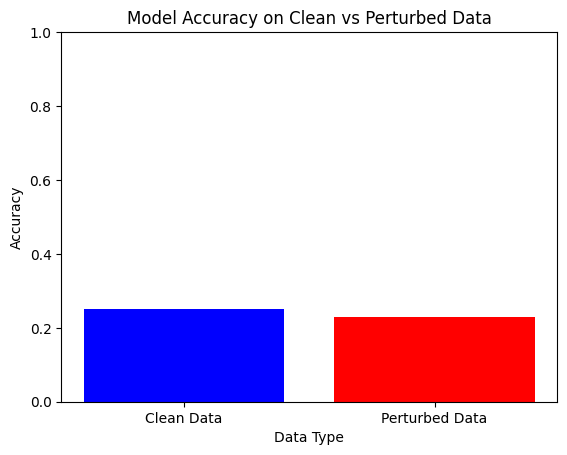

In [ ]:
import matplotlib.pyplot as plt

# Assuming accuracy_perturbed and accuracy_clean are already calculated
accuracies = [accuracy_clean, accuracy_perturbed]
labels = ['Clean Data', 'Perturbed Data']

plt.bar(labels, accuracies, color=['blue', 'red'])
plt.xlabel('Data Type')
plt.ylabel('Accuracy')
plt.title('Model Accuracy on Clean vs Perturbed Data')
plt.ylim([0, 1])  # Assuming accuracy is a fraction
plt.show()


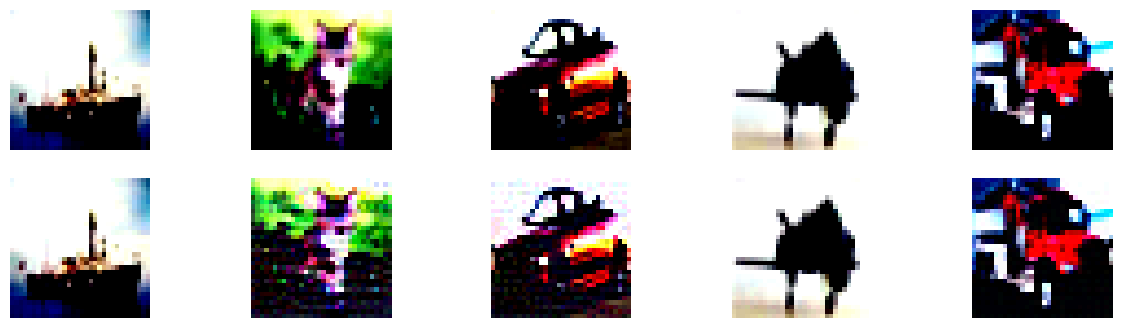

In [ ]:
def plot_examples(data_loader, model, num_images=5):
    images, _ = next(iter(data_loader))
    perturbed_images = torch.stack([deepfool(img.unsqueeze(0), model).squeeze() for img in images[:num_images]]).to(device)

    images = images[:num_images]
    perturbed_images = perturbed_images.cpu()

    fig, axs = plt.subplots(2, num_images, figsize=(15, 4))
    for i in range(num_images):
        axs[0, i].imshow(images[i].permute(1, 2, 0))  # Adjust for image normalization
        axs[1, i].imshow(perturbed_images[i].permute(1, 2, 0))  # Adjust for image normalization
        axs[0, i].axis('off')
        axs[1, i].axis('off')
    axs[0, 0].set_ylabel('Original')
    axs[1, 0].set_ylabel('Perturbed')
    plt.show()

plot_examples(test_loader, model)


In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np

def test_model_with_confusion_matrix(model, data_loader, use_perturbed_data):
    model.eval()  # Ensure the model is in evaluation mode
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    for data, target in data_loader:
        data, target = data.to(device), target.to(device)

        if use_perturbed_data:
            # Temporarily enable gradients for DeepFool
            perturbed_data = []
            for d in data:
                d.requires_grad_()  # Enable gradient computation for DeepFool
                with torch.enable_grad():  # Enable gradients temporarily
                    perturbed_image = deepfool(d.unsqueeze(0), model).squeeze()
                perturbed_data.append(perturbed_image.detach())  # Detach to stop gradient tracking
            data = torch.stack(perturbed_data).to(device)

        # Forward pass without gradient computation
        with torch.no_grad():
            outputs = model(data)
            _, predicted = torch.max(outputs, 1)

        # Collect all predictions and actual labels
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(target.cpu().numpy())

        # Update correct count
        correct += (predicted == target).sum().item()
        total += target.size(0)

    # Calculate the overall accuracy
    accuracy = correct / total

    # Calculate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    return accuracy, cm



In [ ]:
# Testing the model on perturbed data
accuracy_perturbed, cm_perturbed = test_model_with_confusion_matrix(model, test_loader, use_perturbed_data=True)
print(f'Accuracy of the network on perturbed test images: {100 * accuracy_perturbed:.2f}%')
print("Confusion Matrix on Perturbed Data:\n", cm_perturbed)

# Testing the model on clean data
accuracy_clean, cm_clean = test_model_with_confusion_matrix(model, test_loader, use_perturbed_data=False)
print(f'Accuracy of the network on clean test images: {100 * accuracy_clean:.2f}%')
print("Confusion Matrix on Clean Data:\n", cm_clean)


Accuracy of the network on perturbed test images: 22.98%
Confusion Matrix on Perturbed Data:
 [[258 373   2   5   4   3   0  10 339  24]
 [  6 785   0   0   0   1   0   8 146  17]
 [125 333  10  51  30  73   2 190 144  64]
 [ 44 348   3  81   6  98   1 185 161  85]
 [ 50 323   9  68  75  37   4 224 106 104]
 [ 29 245   0  46   6 130   1 281 154  84]
 [ 21 407   2  66  55  24  15 204 101 105]
 [ 20 387   0  24  17  17   0 234  66 242]
 [ 33 327   1   4   1   0   0   3 640  11]
 [  8 787   0   4   1   2   0  11  99  70]]
Accuracy of the network on clean test images: 25.07%
Confusion Matrix on Clean Data:
 [[ 88 501   0   0   1   0  22  53  37 316]
 [  0 466   0   0   0   0  58  29   1 409]
 [ 29 178   0   0   5   0 308 297   3 202]
 [  1 134   0   0   0   0 314 350   1 212]
 [  3 133   0   0   8   0 409 298   4 145]
 [  0 118   0   0   0   0 268 448   2 140]
 [  0  65   0   0   1   0 594 193   1 146]
 [  1  73   0   0   0   0 189 560   1 183]
 [ 12 459   0   0   0   0  18  16  62 453]
 [

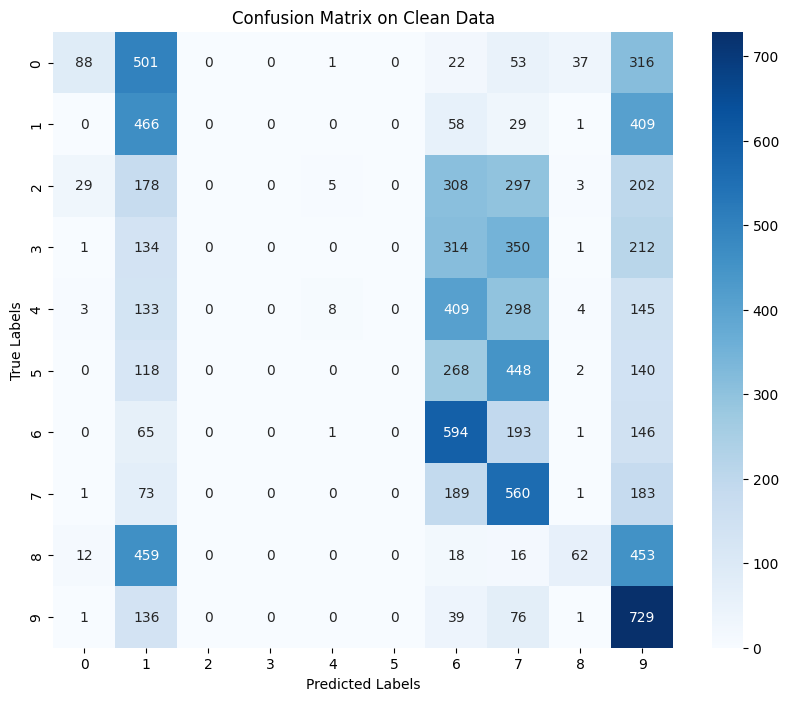

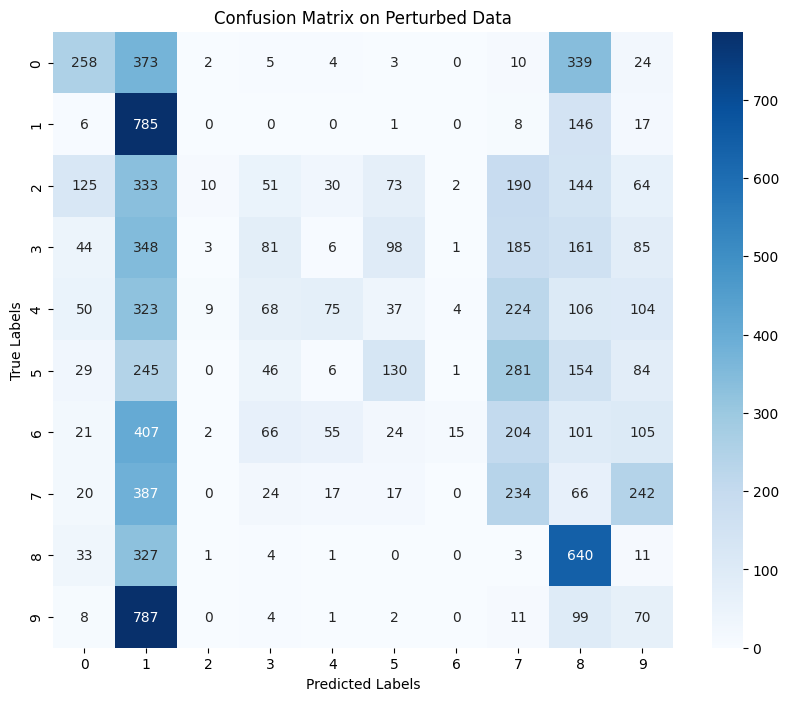

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(title)
    plt.show()

plot_confusion_matrix(cm_clean, "Confusion Matrix on Clean Data")
plot_confusion_matrix(cm_perturbed, "Confusion Matrix on Perturbed Data")
